In [6]:
!pip install transformers datasets torch pandas scikit-learn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score

# Load your dataset
data = pd.read_csv("/kaggle/input/new-datasets-final/final_datasets_new.csv")

# Combine textual features into a single input text including the sentiment_analysis column
def combine_features(row):
    # Combine the text with other extracted features and sentiment_analysis as a feature
    return f"Text: {row['text']} | Objects: {row['detected_objects']} | Emotion: {row['Dominant Emotion']} | " \
           f"Race: {row['Dominant Race']} | Gender: {row['gender']} | Age Group: {row['age_group']} | " \
           f"Sentiment: {row['sentiment_analysis']}"

# Create a combined feature column
data['combined_features'] = data.apply(combine_features, axis=1)

# Use 'label' as the target for classification
labels = data['label']  # Assuming 'label' column is the target (hateful = 1, non-hateful = 0)

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['combined_features'], labels, test_size=0.2, random_state=42
)

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the dataset
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

# Convert the labels to tensors
train_labels = torch.tensor(train_labels.values)
val_labels = torch.tensor(val_labels.values)

# Create PyTorch datasets
class MemeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainingArguments


# Prepare datasets
train_dataset = MemeDataset(train_encodings, train_labels)
val_dataset = MemeDataset(val_encodings, val_labels)

# Load the RoBERTa model for binary classification (hateful or not)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

def compute_metrics(p):
    preds, labels = p
    preds = preds.argmax(axis=1)  # Get the predicted classes (for classification tasks)

    # Calculate precision, recall, f1 score (for binary classification)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    # Calculate accuracy
    acc = accuracy_score(labels, preds)

    # Return the metrics as a dictionary
    return {
        "accuracy": acc, 
        "f1": f1, 
        "precision": precision, 
        "recall": recall
    }


training_args = TrainingArguments(
    output_dir="./results",          # Directory to save model checkpoints
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    learning_rate=1e-5,              # Learning rate
    per_device_train_batch_size=32,  # Batch size for training
    per_device_eval_batch_size=32,   # Batch size for evaluation
    num_train_epochs=25,             # Number of training epochs
    weight_decay=0.01,               # Weight decay
    save_strategy="epoch",          # Save model at the end of each epoch
    save_total_limit=2,              # Only keep the last 2 checkpoints
    logging_dir="./logs",            # Directory for logs
    logging_steps=200,               # Log every 200 steps (can adjust based on your preference)
    logging_first_step=True,         # Log the first step as well
    report_to="none",                # Disable W&B logging (if you don't want to log to Weights & Biases)
    disable_tqdm=False,              # Ensure tqdm is enabled for progress bar
    load_best_model_at_end=True,     # Load the best model at the end of training (based on evaluation metric)
    metric_for_best_model="accuracy",  # Use accuracy to determine the best model
)


# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Pass compute_metrics to Trainer
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("./final_model")  # Specify the directory to save the model
tokenizer.save_pretrained("./final_model")


# Evaluate the model (this will calculate and display accuracy)
eval_results = trainer.evaluate()

# Print evaluation results (including accuracy)
print("Evaluation Results:", eval_results)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather alo

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.719700,0.575424,0.711176,0.511443,0.700272,0.402821
2,0.584900,0.561150,0.712941,0.575652,0.646484,0.518809
3,0.584900,0.585753,0.725294,0.560677,0.701176,0.467085
4,0.490100,0.577614,0.702353,0.577629,0.617857,0.542320
5,0.490100,0.634226,0.695882,0.596409,0.594090,0.598746
6,0.425900,0.676373,0.692941,0.597843,0.587879,0.608150
7,0.425900,0.700499,0.694706,0.609481,0.586107,0.634796
8,0.365200,0.735848,0.691176,0.584323,0.590400,0.578370
9,0.365200,0.740868,0.690000,0.543723,0.607350,0.492163
10,0.316200,0.769388,0.682941,0.566372,0.581818,0.551724


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Evaluation Results: {'eval_loss': 0.5857529044151306, 'eval_accuracy': 0.7252941176470589, 'eval_f1': 0.5606773283160865, 'eval_precision': 0.7011764705882353, 'eval_recall': 0.4670846394984326, 'eval_runtime': 9.4504, 'eval_samples_per_second': 179.887, 'eval_steps_per_second': 2.857, 'epoch': 25.0}


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


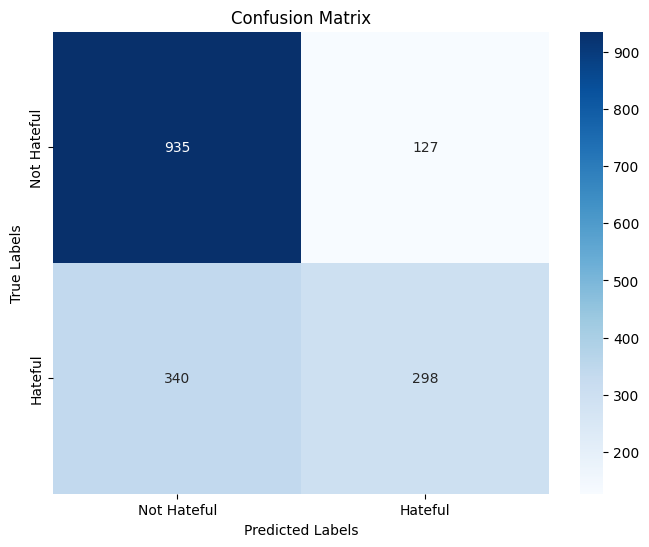

In [55]:
# Predictions for Confusion Matrix
predictions = trainer.predict(val_dataset)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hateful", "Hateful"], yticklabels=["Not Hateful", "Hateful"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

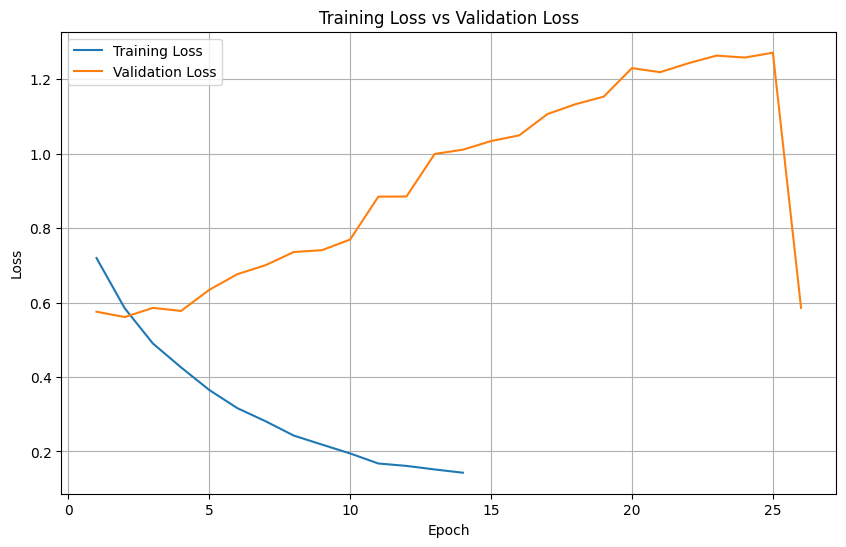

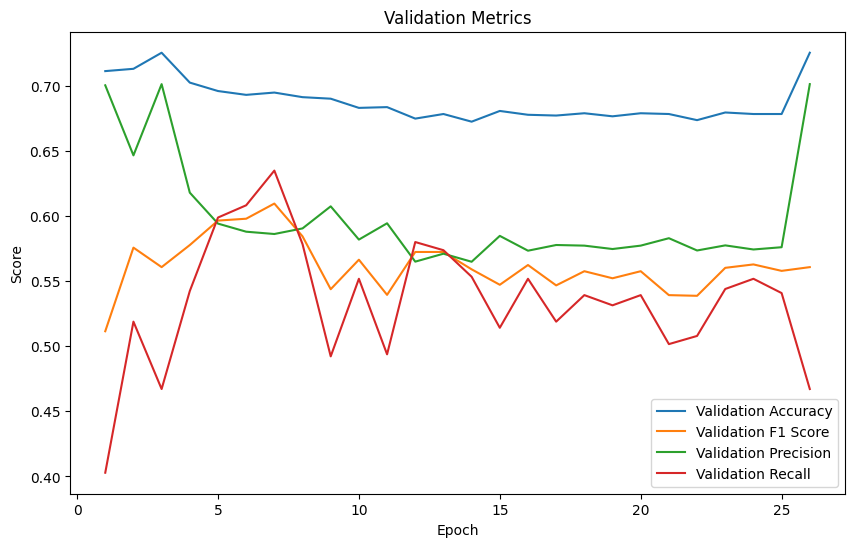

In [56]:
# Extract log history
history = trainer.state.log_history

# Extract metrics
train_loss = [log["loss"] for log in history if "loss" in log]
val_accuracy = [log["eval_accuracy"] for log in history if "eval_accuracy" in log]
val_f1 = [log["eval_f1"] for log in history if "eval_f1" in log]
val_precision = [log["eval_precision"] for log in history if "eval_precision" in log]
val_recall = [log["eval_recall"] for log in history if "eval_recall" in log]

# Ensure that train_accuracy is correctly extracted based on the log structure
train_accuracy = [log["train_accuracy"] for log in history if "train_accuracy" in log]

# Define epochs based on the shortest metric length
epochs = range(1, len(val_accuracy) + 1)

# Extract metrics
train_loss = [log["loss"] for log in history if "loss" in log]
val_loss = [log["eval_loss"] for log in history if "eval_loss" in log]

# Plot Training Loss vs Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.plot(epochs, val_f1, label="Validation F1 Score")
plt.plot(epochs, val_precision, label="Validation Precision")
plt.plot(epochs, val_recall, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.legend()
plt.show()
